## Analysis of the Modes in the Latent Space ##

In this notebook, we will demonstrate how the team conducted the physical analysis of the modes in the latent space. The best performing autoencoder developed by the team possessed four modes in its latent space, and based on this a hierarchical autoencoder was developed utilising the same number of modes in its latent space. Due to its inherent property of producing ordered modes, this latter model is the one that will be used in the present investigation.

Firstly, we will create a trained model, after which we will define a number of functions to enable the visualization of the effects of introducing each mode. We can then select, as an example, a certain frame from which to take the latent space for our exploration.

In [9]:
from FlowCompression import AE
import matplotlib.pyplot as plt
import numpy as np
from FlowCompression import AE
import sys
sys.path.append('.')

#Create a trained model, considering both u and v velocity. Passing argument 2 means creating a hierarchical model.
model = AE.create_trained(2)

#All the frames of the flow data given by the client.
u_all = AE.preprocess(split=False)

Now that we have our model, some functions can be defined for visualization.

In [10]:
def generation_from_original(time_series):
    """
    Generate latent spaces given a certain time series of flows
    :param time_series: series of frame taken from the data set provided by the client
    :return: array of all the latent spaces related to such time frames
    """
    latent_space_original = model.encode(time_series)
    return latent_space_original


def generate(latent_space):
    """
    Generate artificial flow from a given latent space
    :param latent_space: [m1,m2,m3,m4], values between -1 to 1
    :return: artificial flow [24,24,2]
    """
    artificial = model.decode(np.array([[[latent_space]]]))
    return artificial


# ------- ANALYSIS OF THE HIERARCHICAL AUTOENCODER ----

def hierarchical_visual(time_series, n_frame):
    """
    Plots the reconstruction effects of the different modes given an initial frame to reconstruct
    :param time_series: time series of frame where to choose from
    :param n_frame: fram number which should be used as a starting point for the reconstruction
    :return: None
    """
    # Generate latent space related to the frame selected
    final_latent = model.encode(u_all[n_frame])[0, 0, 0, :]

    # To see the effect of every mode, every previous component should take the value from 'final_latent' while the
    # next components should be 0
    latent_1 = [final_latent[0], 0, 0, 0]
    latent_2 = [final_latent[0], final_latent[1], 0, 0]
    latent_3 = [final_latent[i] for i in range(3)] + [0]

    # generate flow with each personalized latent. Subtraction is needed to eliminate effects of previous modes
    m1_effect = generate(latent_1)
    m2_effect = generate(latent_2) - m1_effect
    m3_effect = generate(latent_3) - generate(latent_2)
    m4_effect = generate(final_latent) - generate(latent_3)

    # Plot the reconstructed flow and the effects of each mode (different cmap for m2, m3, m4 because both + and -
    AE.u_v_plot(generate(final_latent))
    AE.u_v_plot(m1_effect, title=f'Effect of mode 1 with latent {latent_1}')
    AE.u_v_plot(m2_effect, title=f'Effect of mode 2 with latent {latent_2}', color='seismic', vmin=None, vmax=None)
    AE.u_v_plot(m3_effect, title=f'Effect of mode 3 with latent {latent_3}', color='seismic', vmin=None, vmax=None)
    AE.u_v_plot(m4_effect, title=f'Effect of mode 4 with latent {final_latent}', color='seismic', vmin=None, vmax=None)


Now that we have a model and functions to analyze the modes in this model, a frame can be selected to conduct the visualization. The team randomly selected the 52nd frame of the total given frames, which was also used in the report. By calling hierarchical_visual(u_all, 51), the plots showing the effect of including each additional mode to the latent space of frame 51 will be shown.

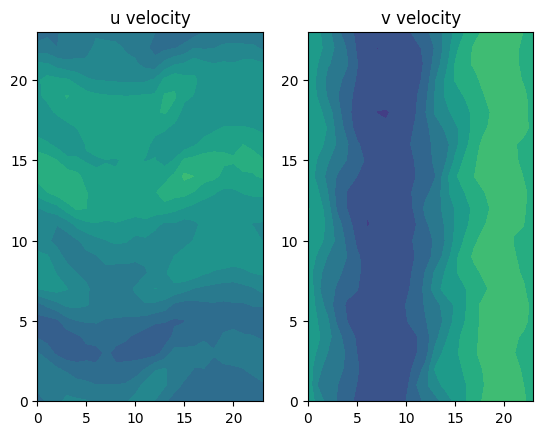

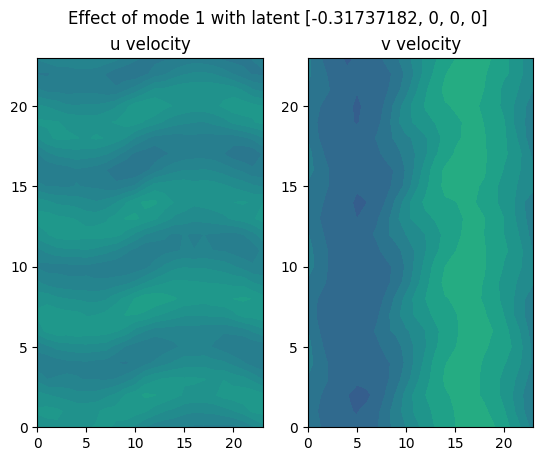

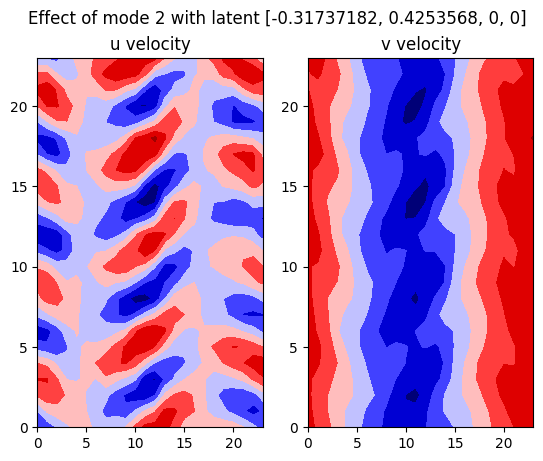

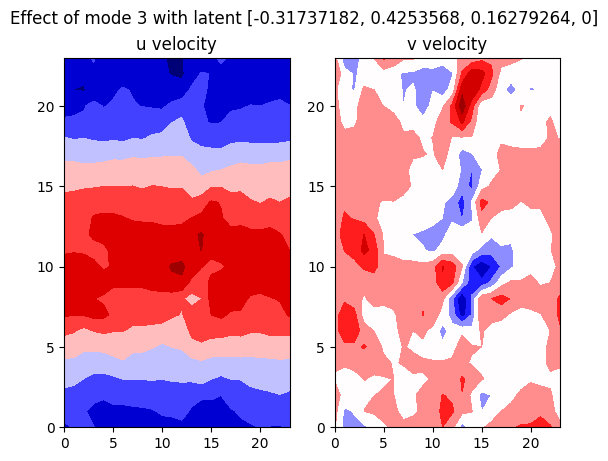

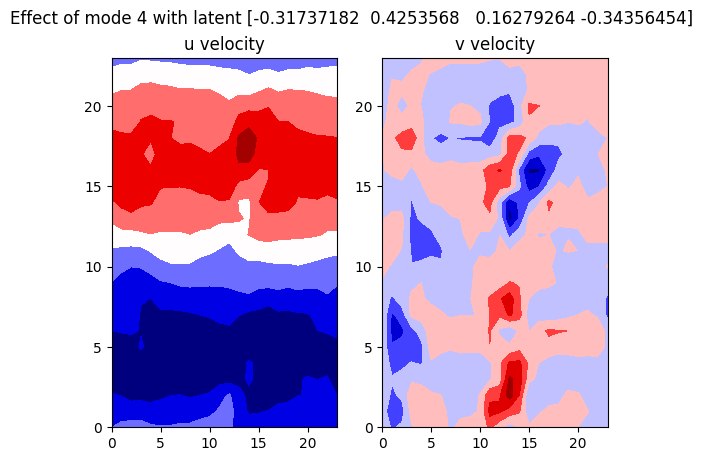

In [11]:
hierarchical_visual(u_all, 51)

With these plots, we can now make the same conclusions regarding the behaviour of each mode as were laid out in the report. To further characterize this, we can now visualize the effects of including a small disturbance to each mode, both increasing and decreasing the original value for that mode. We first define a domain, so that

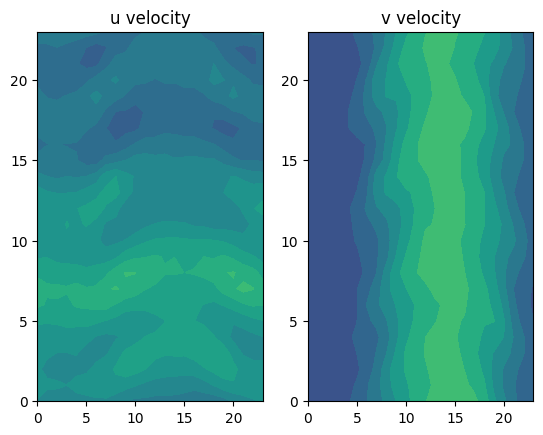

In [12]:
# Determine the domain over which the disturbance will be taken
domain = np.arange(-0.1, 0.2, 0.1)

# Take one sample from data set and calculate latent space
sample_latent = model.encode(u_all[0])  # [[[[-0.03541018  0.24589653  0.5007892  -0.19181845]]]]

# Plot the original reconstructed flow
AE.u_v_plot(model.decode(sample_latent))



Before analysing the effect of the reconstructed flow due to a disturbance, a function to asses the physical characteristics (curl, energy) of the flow field is generated.

In [13]:
def function(frame):
    return AE.curl(frame), AE.energy(frame)

Another important step before generating artificial flows is to determine what is the average curl and average energy of the original frame. With these values, a physical comparison can be drawn.

In [14]:
print(f'Average Divergence: {np.average(function(u_all[0])[0])}\nAverage Energy: {np.average(function(u_all[0])[1])}')

Average Divergence: 4.818676322157797e-20
Average Energy: 0.28198361614851825


The function below displays the differences in the generated flow data due to the addition of various disturbances to the specified mode of the latent space. The parameter mode can be changed depending on which latent space component is desired to focus on. Some lines of the code are commented out, these are needed in case the user would like to plot the changes in divergence and curl as the latent space disturbance changes through the domain. These quantities can also be plotted, but these code lines are not provided.

In [15]:
def disturbance_effects(mode):
    """
    Function to display the differences in the generated flow data due to the addition of various disturbances to the specified mode of the latent space.
    :param mode: latent space mode to be disturbed
    :return: None, plots figure
    """""
    ## curls = []
    ## energies = []
    for i in domain:
        disturbed_latent = np.copy(sample_latent)
        disturbed_latent[0, 0, 0, mode] = sample_latent[0, 0, 0, mode] * (1 + i)
        img_disturbed = model.decode(disturbed_latent)
        img_sample = model.decode(sample_latent)
        energy_difference = np.subtract(AE.energy(img_disturbed), AE.energy(img_sample))
        img = np.subtract(img_disturbed, img_sample)
        ## curl, energy = function(img_disturbed)
        ## curls.append(np.average(curl))
        ## energies.append(np.average(energy))
        AE.u_v_curl_plot(img, energy_difference, f'Latent space change   {sample_latent[0][0][0]}   to   {disturbed_latent[0][0][0]}  ')


Now that the function has been implemented, it can be called using as a parameter the relevant latent space mode. The input can be any number lower than the dimensions of the latent space and if the user wants to change the disturbances, the 'domain' variable should be modified.

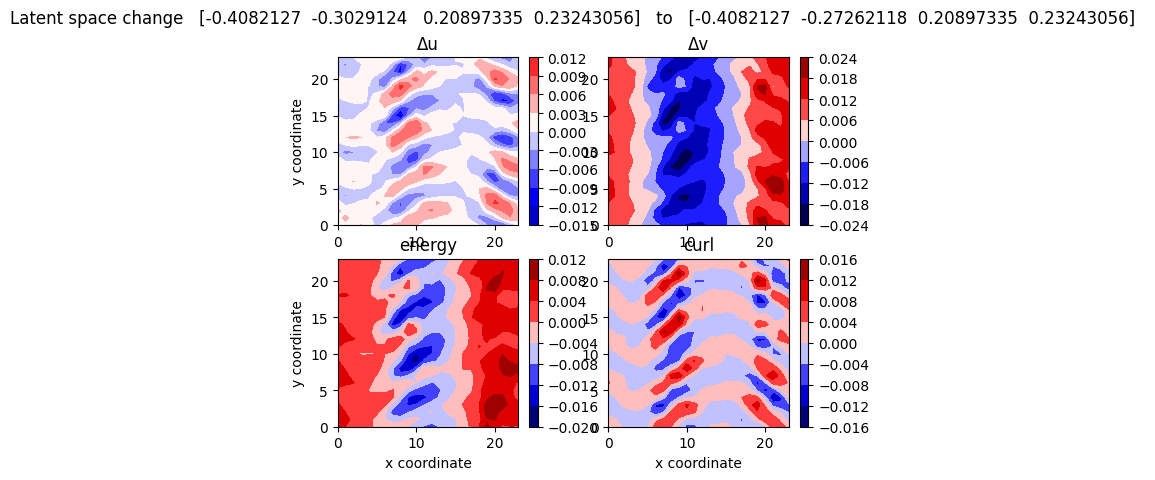

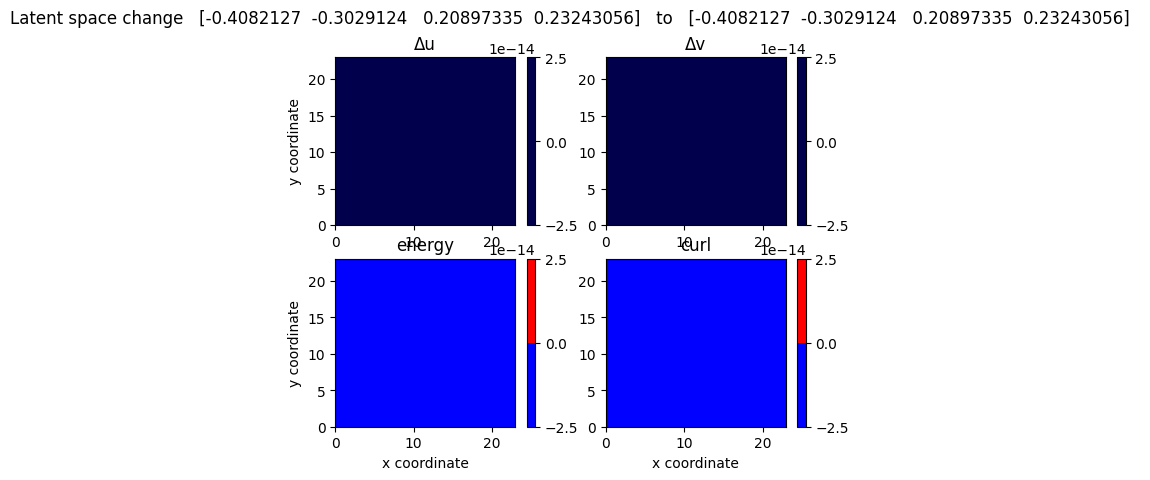

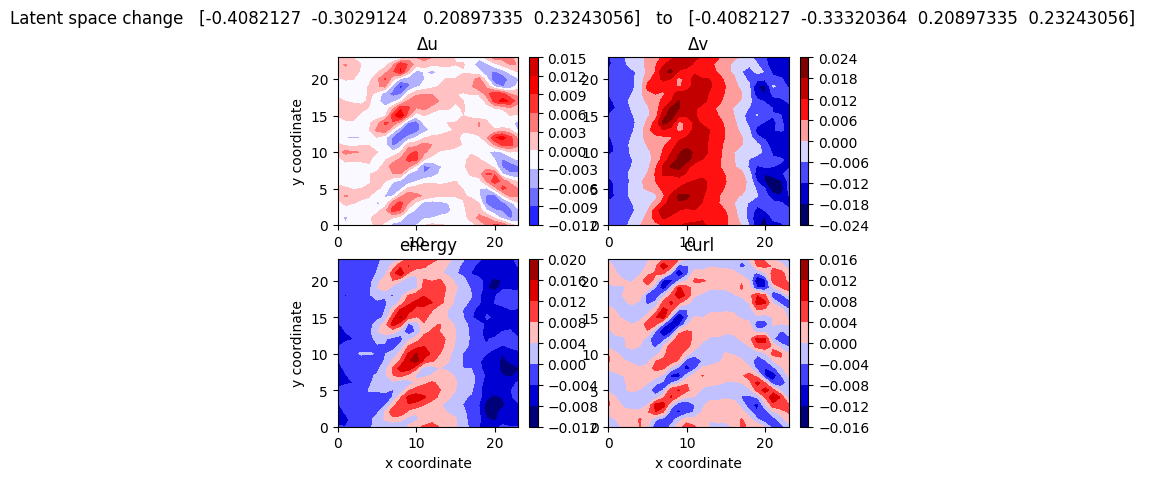

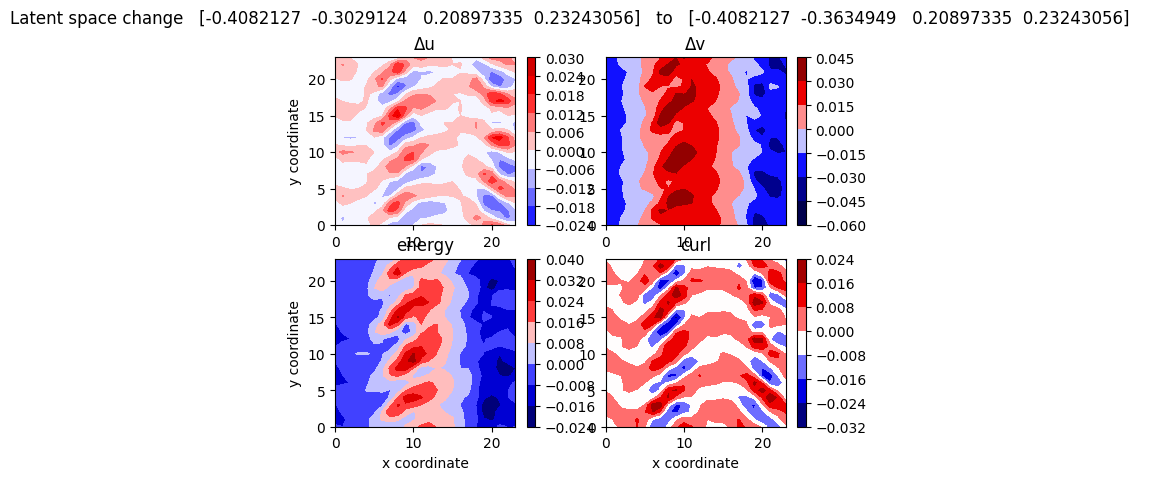

In [16]:
disturbance_effects(1)